In [31]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import quaternion
from mpl_toolkits.mplot3d import Axes3D


# Orientation estimation using extended kalman filter
  Based on: X. Yun and E. R. Bachmann, ‘Design, Implementation, and Experimental Results of a Quaternion-Based Kalman Filter for Human Body Motion Tracking’, IEEE Trans. Robot., vol. 22, no. 6, pp. 1216–1227, Dec. 2006, doi: 10.1109/TRO.2006.886270.
  
The state vector contains 3D angular velocity and quaternion: $$
\vec{x} = \begin{pmatrix} \omega_x & \omega_y & \omega_z & q_1 & q_2 & q_3 & q_4 \end{pmatrix}^T
$$


In [32]:
# this is the Jacobian (linearized version) of the state transition, equation (13)
def phi(x, Ts, tau1, tau2, tau3):
    return np.array([[np.exp(-Ts/tau1), 0, 0, 0, 0, 0, 0],
                    [0, np.exp(-Ts/tau2), 0, 0, 0, 0, 0],
                    [0, 0, np.exp(-Ts/tau3), 0, 0, 0, 0],
                    [-(x[4]*Ts)/2, -(x[5]*Ts)/2, -(x[6]*Ts)/2, 1, -(x[0]*Ts)/2, -(x[1]*Ts)/2, -(x[2]*Ts)/2],
                    [(x[3]*Ts)/2, -(x[6]*Ts)/2, (x[5]*Ts)/2, (x[0]*Ts)/2, 1, (x[2]*Ts)/2, -(x[1]*Ts)/2],
                    [(x[6]*Ts)/2, (x[3]*Ts)/2, -(x[4]*Ts)/2, (x[1]*Ts)/2, -(x[2]*Ts)/2, 1, (x[0]*Ts)/2],
                    [-(x[5]*Ts)/2, (x[4]*Ts)/2, (x[3]*Ts)/2, (x[2]*Ts)/2, (x[1]*Ts)/2, -(x[0]*Ts)/2, 1]])

def quaternion_to_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2 * y ** 2 - 2 * z ** 2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x ** 2 - 2 * z ** 2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x ** 2 - 2 * y ** 2]
    ])

In [33]:
kf = KalmanFilter(dim_x=7, dim_z=7)
kf.x = np.array([0,0,0,0,0,0,0])
Ts = 0.04  # 25Hz samples

kf.H = np.eye(7)

tau1 = 0.7
tau2 = 0.7
tau3 = 0.7
D = 0.1

q11 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau1))
q22 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau2))
q33 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau3))

kf.Q = np.array([
    [q11, 0, 0, 0, 0, 0, 0],
    [0, q22, 0, 0, 0, 0, 0],
    [0, 0, q33, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]])

kf.R =  np.array([
    [0.01, 0, 0, 0, 0, 0, 0],
    [0, 0.01, 0, 0, 0, 0, 0],
    [0, 0, 0.01, 0, 0, 0, 0],
    [0, 0, 0, 0.0001, 0, 0, 0],
    [0, 0, 0, 0, 0.0001, 0, 0],
    [0, 0, 0, 0, 0, 0.0001, 0],
    [0, 0, 0, 0, 0, 0, 0.0001]])

kf.P *= 1000

In [34]:
# Initial position and velocity
initial_position = np.array([0.0, 0.0, 0.0])
positions = [initial_position]  # Store the initial position
current_position = initial_position

# Store positions for plotting
measured_positions = []
predicted_positions = []
predicted_quaternions = []

df = pd.read_csv('spiral_data/sensor_data_down_b.csv')

for i, row in df.iterrows():
    # z y x
    z = [row['Gyro_X']*(np.pi/180), row['Gyro_Y']*(np.pi/180), row['Gyro_Z']*(np.pi/180),
         row['Quaternion_W'], row['Quaternion_X'], row['Quaternion_Y'], row['Quaternion_Z']]
    
    kf.F = phi(kf.x, Ts, tau1, tau2, tau3)  # Predict with Kalman filter
    kf.predict()
    kf.update(z)
    
    # Predicted Quaternion
    x = kf.x
    q = np.array([x[3], x[4], x[5], x[6]])  # Quaternion w, x, y, z
        
    # Convert quaternion to rotation matrix
    R = quaternion_to_matrix(q)
    
    # Linearize angular velocity (convert from radians/second to m/s)
    v = [v[0] + row['Accel_X']*Ts, v[1] + row['Accel_Y']*Ts, v[2]+ row['Accel_Z']*Ts]  # Adjust as needed
    #v=np.array([0.1, 0, 0])
    
    current_position = current_position + R @ v  # Update with time step
    positions.append(current_position)  # Append the updated position to the list
    predicted_quaternions.append(q)

# Convert positions to numpy array for analysis
positions = np.array(positions)
predicted_quaternions = np.array(predicted_quaternions)

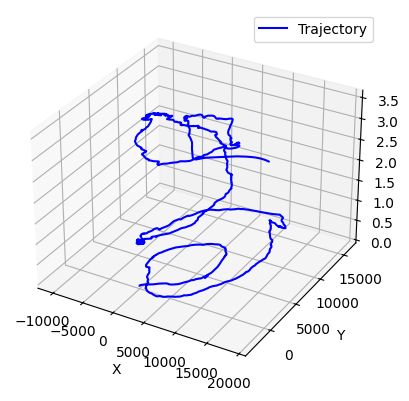

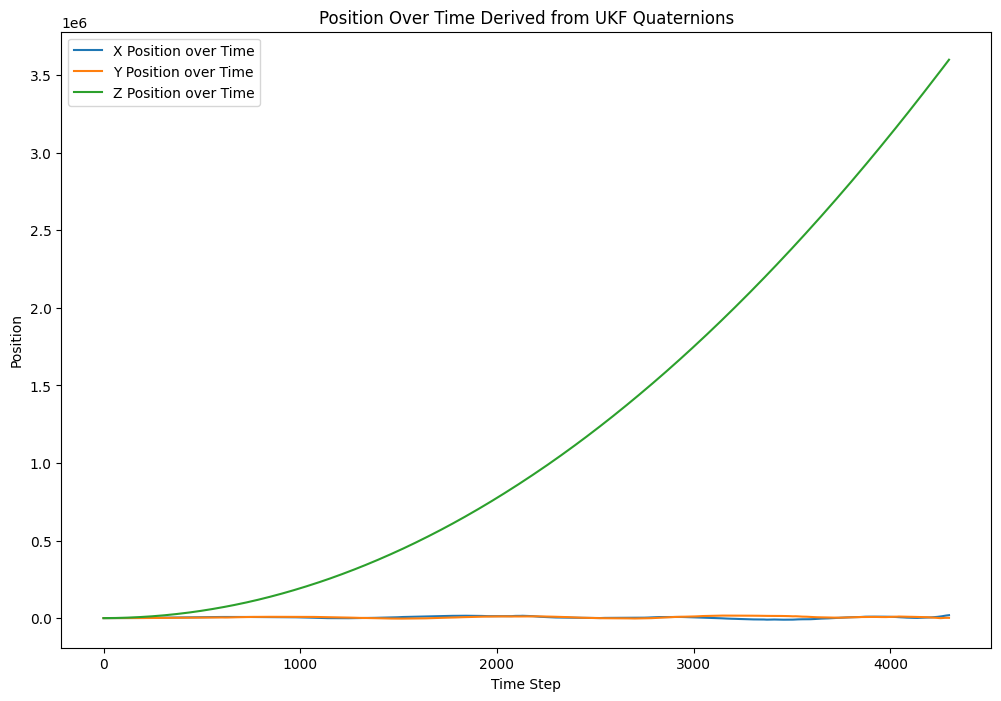

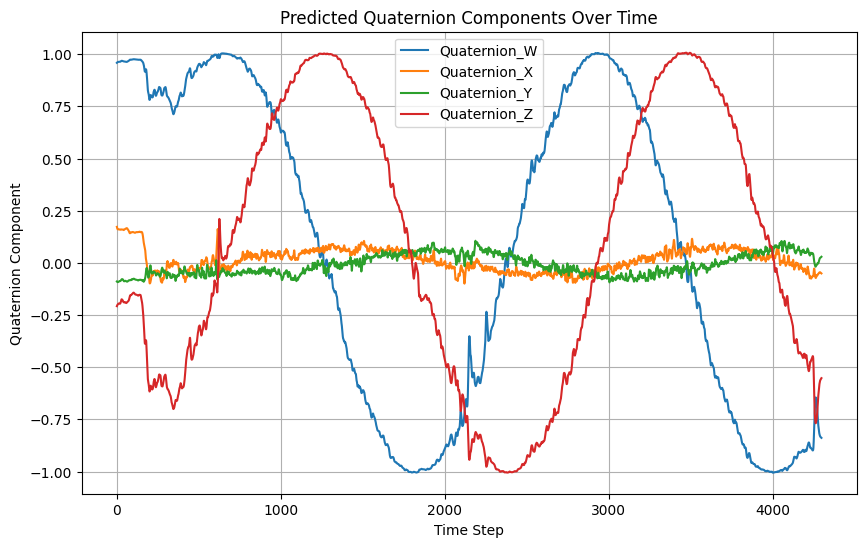

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot measured position
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Trajectory', color='blue')

# Plot predicted positions
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

# Plot positions over time
plt.figure(figsize=(12, 8))
plt.plot(positions[:, 0], label='X Position over Time')
plt.plot(positions[:, 1], label='Y Position over Time')
plt.plot(positions[:, 2], label='Z Position over Time')
plt.title('Position Over Time Derived from UKF Quaternions')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(predicted_quaternions[:, 0], label='Quaternion_W')
plt.plot(predicted_quaternions[:, 1], label='Quaternion_X')
plt.plot(predicted_quaternions[:, 2], label='Quaternion_Y')
plt.plot(predicted_quaternions[:, 3], label='Quaternion_Z')
plt.xlabel('Time Step')
plt.ylabel('Quaternion Component')
plt.title('Predicted Quaternion Components Over Time')
plt.legend()
plt.grid()
plt.show()
